# Gradient and Adaptive boosting:

In [ ]:
import re
import nltk
import chardet
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_score, GridSearchCV

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# !pip install kaggle     # uncomment if not installed

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Reading dataset:

In [ ]:
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

 73% 59.0M/80.9M [00:00<00:00, 230MB/s]
100% 80.9M/80.9M [00:00<00:00, 224MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
try:
    df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin1')
except UnicodeDecodeError:
    print("UnicodeDecodeError occurred.")

In [ ]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
df.loc[len(df)] = np.nan
df = df.shift()                                                                 # shifting all rows down by one so we can rename the columns
df.columns, df.iloc[0] = df.iloc[0].to_list(), df.columns

In [ ]:
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df['target'][0] = 0.0
df

,target,id,date,flag,user,text
0,0.0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0.0,1467810672.0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0.0,1467810917.0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0.0,1467811184.0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0.0,1467811193.0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4.0,2193601966.0,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4.0,2193601969.0,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4.0,2193601991.0,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4.0,2193602064.0,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Data exploration:

In [ ]:
print("Dataset Overview:")
print(df.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  object
 1   id      1600000 non-null  object
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: object(6)
memory usage: 85.4+ MB
None


In [ ]:
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
           target            id                          date      flag  \
count   1600000.0  1.600000e+06                       1600000   1600000   
unique        2.0  1.598315e+06                        774363         1   
top           0.0  2.190458e+09  Mon Jun 15 12:53:14 PDT 2009  NO_QUERY   
freq     800000.0  2.000000e+00                            20   1600000   

            user                       text  
count    1600000                    1600000  
unique    659775                    1581466  
top     lost_dog  isPlayer Has Died! Sorry   
freq         549                        210  


In [ ]:
target_counts = df['target'].value_counts()
print(target_counts)

0.0    800000
4.0    800000
Name: target, dtype: int64


In [ ]:
max_tweet_date = df['date'].value_counts().idxmax()
min_tweet_date = df['date'].value_counts().idxmin()

print("Most tweets were on:", max_tweet_date)
print("Least tweets were on:", min_tweet_date)

Most tweets were on: Mon Jun 15 12:53:14 PDT 2009
Least tweets were on: Mon May 04 02:28:20 PDT 2009


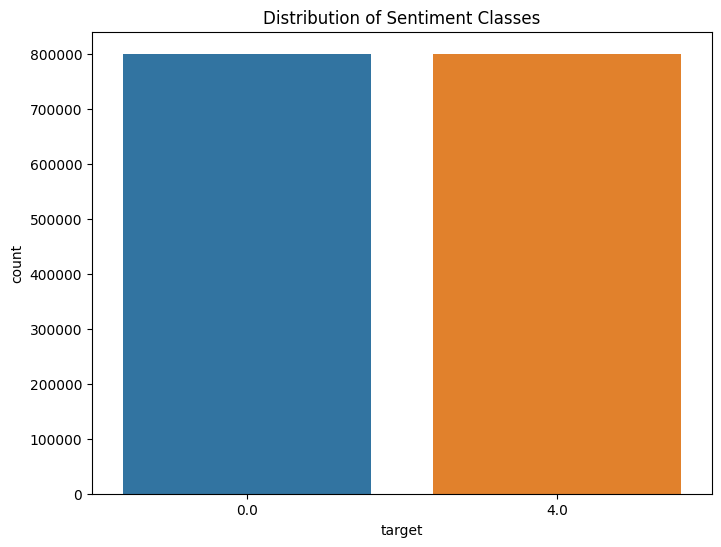

In [ ]:
plt.figure(figsize = (8, 6))
sns.countplot(x = "target", data = df)
plt.title("Distribution of Sentiment Classes")
plt.show()

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


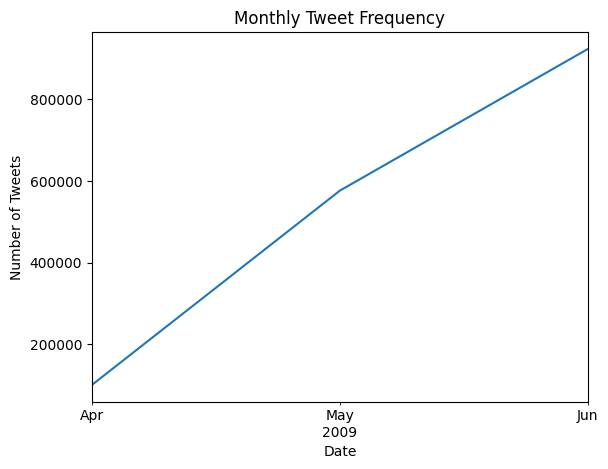

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.resample('M').size().plot()
plt.title('Monthly Tweet Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
user_tweet_counts = df['user'].value_counts()
print("\nTop 5 Users with the Most Tweets:\n", user_tweet_counts.head())


Top 5 Users with the Most Tweets:
 lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
Name: user, dtype: int64


### Data pre-processing:

In [ ]:
def clean_text(series):
    series = series.apply(lambda text: re.sub(r"http\S+|www\S+|https\S+|\@\w+|\#", "", text))
    series = series.apply(lambda text: re.sub(r"[^\w\s]", "", text))
    series = series.apply(lambda text: text.lower())

    return series

In [ ]:
df['clean_text'] = clean_text(df['text'])

In [ ]:
def tokenize_text(series):
    return series.apply(lambda text: word_tokenize(text))

In [ ]:
df['tokens'] = tokenize_text(df['clean_text'])

In [ ]:
def remove_stopwords(series):
    stop_words = set(stopwords.words('english'))
    return series.apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

In [ ]:
df['filtered_tokens'] = remove_stopwords(df['tokens'])

In [ ]:
def lemmatize_series(series):
    lemmatizer = WordNetLemmatizer()
    return series.apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

In [ ]:
df['lemmatized_tokens'] = lemmatize_series(df['filtered_tokens'])

In [ ]:
df

,target,id,flag,user,text,clean_text,tokens,filtered_tokens,lemmatized_tokens
date,,,,,,,,,
2009-04-06 22:19:45,0.0,1467810369,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",a thats a bummer you shoulda got david car...,"[a, thats, a, bummer, you, shoulda, got, david...","[thats, bummer, shoulda, got, david, carr, thi...","[thats, bummer, shoulda, got, david, carr, thi..."
2009-04-06 22:19:49,0.0,1467810672.0,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...,"[is, upset, that, he, cant, update, his, faceb...","[upset, cant, update, facebook, texting, might...","[upset, cant, update, facebook, texting, might..."
2009-04-06 22:19:53,0.0,1467810917.0,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...","[dived, many, time, ball, managed, save, 50, r..."
2009-04-06 22:19:57,0.0,1467811184.0,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, body, feel, itchy, like, fire]"
2009-04-06 22:19:57,0.0,1467811193.0,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i he...,"[no, its, not, behaving, at, all, im, mad, why...","[behaving, im, mad, cant, see]","[behaving, im, mad, cant, see]"
...,...,...,...,...,...,...,...,...,...
2009-06-16 08:40:49,4.0,2193601966.0,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...,"[just, woke, up, having, no, school, is, the, ...","[woke, school, best, feeling, ever]","[woke, school, best, feeling, ever]"
2009-06-16 08:40:49,4.0,2193601969.0,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom very cool to hear old walt intervie...,"[thewdbcom, very, cool, to, hear, old, walt, i...","[thewdbcom, cool, hear, old, walt, interviews, â]","[thewdbcom, cool, hear, old, walt, interview, â]"
2009-06-16 08:40:49,4.0,2193601991.0,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...,"[are, you, ready, for, your, mojo, makeover, a...","[ready, mojo, makeover, ask, details]","[ready, mojo, makeover, ask, detail]"


### Model:

In [ ]:
X = df['text']
y = df['target']

le = LabelEncoder()                                                             # encoding the target variable
y = le.fit_transform(y)

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)   # stratified sampling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
vectorizer = CountVectorizer()                                                  # CountVectorizer + pipeline
pipeline_gbm = make_pipeline(vectorizer, GradientBoostingClassifier(random_state=42, n_iter_no_change=5, tol=1e-4))
pipeline_adaboost = make_pipeline(vectorizer, AdaBoostClassifier(random_state=42))

param_grid_gbm = {'gradientboostingclassifier__n_estimators': [50, 100, 200], 'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.2]}
param_grid_adaboost = {'adaboostclassifier__n_estimators': [50, 100, 200], 'adaboostclassifier__learning_rate': [0.01, 0.1, 0.2]}

random_search_gbm = RandomizedSearchCV(pipeline_gbm, param_grid_gbm, cv=stratified_kfold, scoring='roc_auc')
random_search_adaboost = RandomizedSearchCV(pipeline_adaboost, param_grid_adaboost, cv=stratified_kfold, scoring='roc_auc')

In [ ]:
random_search_gbm.fit(X_train, y_train)
random_search_adaboost.fit(X_train, y_train)

y_pred_proba_gbm = random_search_gbm.predict_proba(X_test)[:, 1]
y_pred_proba_adaboost = random_search_adaboost.predict_proba(X_test)[:, 1]

In [ ]:
roc_auc_gbm = roc_auc_score(y_test, y_pred_proba_gbm)
roc_auc_adaboost = roc_auc_score(y_test, y_pred_proba_adaboost)

print("\nROC-AUC for GBM:", roc_auc_gbm)
print("ROC-AUC for AdaBoost:", roc_auc_adaboost)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



ROC-AUC for GBM: 0.772515265625
ROC-AUC for AdaBoost: 0.7263548125
